### 1. Modeling and System Identification

#### 1.1. Basic Knowledge

Nominal Transfer Functions

$G_{\theta , 0} = \dfrac{1547.4}{(s^2 + 10.12s + 390.4)(s + 5.373)}$

$G_{\phi , 0} = \dfrac{2049.5}{(s^2 + 19.03s + 426.2)(s + 6.764)}$

<br>

Unstructured Uncertainty -> Multiplicative Perturbation

$W_{\theta}(s) = \dfrac{1659.6(s^2 + 2.868s + 60.44)}{(s + 9.678)(s + 24770)}$

$W_{\phi}(s) = \dfrac{1.9017(s^2 + 3.813s + 91.61)}{(s^2 + 43.53s + 545.3)}$

#### Why Not MIMO?
Practical Constraints:
Open-loop instability made MIMO identification challenging.

Pilot difficulty during experiments (Section 2.1: "experimental data is better obtained for each channel separately").

Simplification:
The authors prioritized feasibility over theoretical MIMO rigor, noting that coupling effects were small near hover conditions.

In [1]:
s = tf('s');

% Nominal Transfer functions
G_theta = 1547.4 / ((s^2 + 10.12*s + 390.4)*(s + 5.373))
G_phi = 2049.5 / ((s^2 + 19.03*s + 426.2)*(s + 6.764))

% Weighting Functions
W_theta = 1659.6*(s^2 + 2.868*s + 60.44) / ((s + 9.678)*(s + 24770))
W_phi = 1.9017*(s^2 + 3.813*s + 91.61) / (s^2 + 43.53*s + 545.3)


ans =

    '9.7.0.1190202 (R2019b)'


G_theta =
 
                1547
  --------------------------------
  s^3 + 15.49 s^2 + 444.8 s + 2098
 
Continuous-time transfer function.


G_phi =
 
                2050
  --------------------------------
  s^3 + 25.79 s^2 + 554.9 s + 2883
 
Continuous-time transfer function.


W_theta =
 
  1660 s^2 + 4760 s + 1.003e05
  ----------------------------
  s^2 + 2.478e04 s + 2.397e05
 
Continuous-time transfer function.


W_phi =
 
  1.902 s^2 + 7.251 s + 174.2
  ---------------------------
     s^2 + 43.53 s + 545.3
 
Continuous-time transfer function.



#### 1.2. Modeling Uncertain SISO Systems in Matlab

In [3]:
% Create uncertain systems
delta_theta = ultidyn('delta_theta', [1 1]); % [1 1] -> SISO Approach
delta_phi = ultidyn('delta_phi', [1 1]);

% Pertured Transfer Functions
G_theta_unc = G_theta * (1 + W_theta * delta_theta)
G_phi_unc = G_phi * (1 + W_phi * delta_phi)


G_theta_unc =

  Uncertain continuous-time state-space model with 1 outputs, 1 inputs, 5 states.
  The model uncertainty consists of the following blocks:
    delta_theta: Uncertain 1x1 LTI, peak gain = 1, 1 occurrences

Type "G_theta_unc.NominalValue" to see the nominal value, "get(G_theta_unc)" to see all properties, and "G_theta_unc.Uncertainty" to interact with the uncertain elements.


G_phi_unc =

  Uncertain continuous-time state-space model with 1 outputs, 1 inputs, 5 states.
  The model uncertainty consists of the following blocks:
    delta_phi: Uncertain 1x1 LTI, peak gain = 1, 1 occurrences

Type "G_phi_unc.NominalValue" to see the nominal value, "get(G_phi_unc)" to see all properties, and "G_phi_unc.Uncertainty" to interact with the uncertain elements.



#### 1.3. Uncertainty Visualization

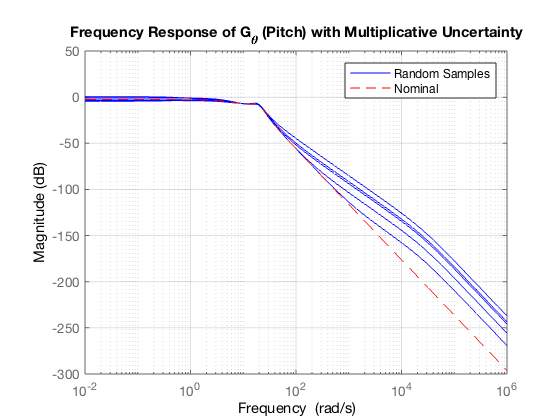

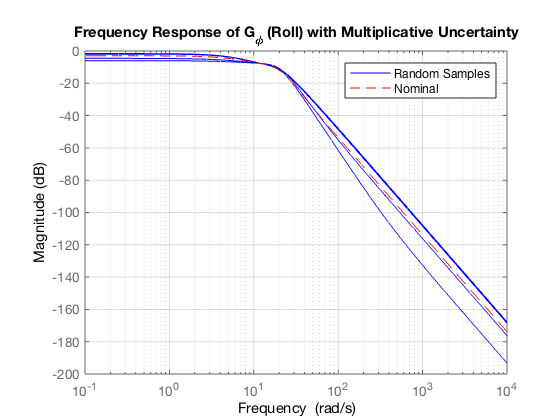

In [4]:
% Generate custom number of samples (The default number is 20)
num_samples = 5;
G_theta_samples = usample(G_theta_unc, num_samples);
G_phi_samples = usample(G_phi_unc, num_samples);

% Bode Plots of both Nominal and Uncertain Systems
figure;
bodemag(G_theta_samples, 'b', G_theta, 'r--');
title('Frequency Response of G_{\theta} (Pitch) with Multiplicative Uncertainty');
legend('Random Samples', 'Nominal');
grid on;

figure;
bodemag(G_phi_samples, 'b', G_phi, 'r--');
title('Frequency Response of G_{\phi} (Roll) with Multiplicative Uncertainty');
legend('Random Samples', 'Nominal');
grid on;

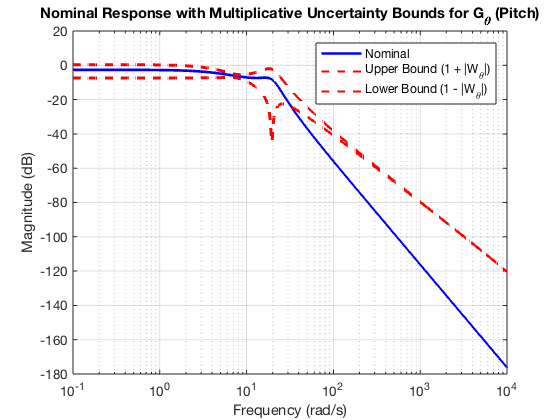

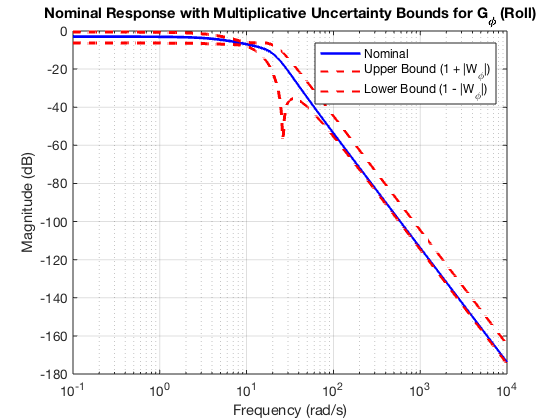

In [5]:
omega = logspace(-1, 4, 500);

% Frequency Responses
[mag_theta, phase_theta] = bode(G_theta, omega);
mag_theta = squeeze(mag_theta); % Remove singleton dimensions

[mag_W_theta, ~] = bode(W_theta, omega);
mag_W_theta = squeeze(mag_W_theta);

[mag_phi, phase_phi] = bode(G_phi, omega);
mag_phi = squeeze(mag_phi);

[mag_W_phi, ~] = bode(W_phi, omega);
mag_W_phi = squeeze(mag_W_phi);

% Uncertainty Bounds
upper_theta = mag_theta .* (1 + mag_W_theta);
lower_theta = mag_theta .* (1 - mag_W_theta);

upper_phi = mag_phi .* (1 + mag_W_phi);
lower_phi = mag_phi .* (1 - mag_W_phi);

% Plotting
figure;

% --- Pitch (G_theta) ---
semilogx(omega, 20*log10(mag_theta), 'b', 'LineWidth', 2); hold on;
semilogx(omega, 20*log10(upper_theta), 'r--', 'LineWidth', 1.5);
semilogx(omega, 20*log10(lower_theta), 'r--', 'LineWidth', 1.5);
title('Nominal Response with Multiplicative Uncertainty Bounds for G_\theta (Pitch)');
xlabel('Frequency (rad/s)');
ylabel('Magnitude (dB)');
legend('Nominal', 'Upper Bound (1 + |W_\theta|)', 'Lower Bound (1 - |W_\theta|)');
grid on;

% --- Roll (G_phi) ---
figure;
semilogx(omega, 20*log10(mag_phi), 'b', 'LineWidth', 2); hold on;
semilogx(omega, 20*log10(upper_phi), 'r--', 'LineWidth', 1.5);
semilogx(omega, 20*log10(lower_phi), 'r--', 'LineWidth', 1.5);
title('Nominal Response with Multiplicative Uncertainty Bounds for G_\phi (Roll)');
xlabel('Frequency (rad/s)');
ylabel('Magnitude (dB)');
legend('Nominal', 'Upper Bound (1 + |W_\phi|)', 'Lower Bound (1 - |W_\phi|)');
grid on;

#### 1.4. Objectives and Pre-requirements

Settling Time $\approx 0.3 s$

Overshoot $\approx 0$

Steady State Error $\approx 0$

Control Effort Limitations

### 2. Robust H∞ Control Synthesis

#### 2.1. Claculations of Weighting Functions

#### A) Sensivity Weighting Function</b>

Assumption: Second Order Closed-Loop System

Closed-Loop Transfer Function (Ideal Function):

$T_{cl}(s) = \dfrac{\omega_n^2}{s^2 + 2\zeta\omega_ns + \omega_n^2}$

Peak Overshoot: (Step Input)

$M_p = exp(-\dfrac{\pi\zeta}{\sqrt{1 - \zeta^2}}) \approx 10^{-6}$

$\zeta = \dfrac{-ln(M_p)}{\sqrt{\pi^2 + (ln(M_p))^2}}$

Settling Time:

$t_s \approx \dfrac{4}{\zeta\omega_n} \approx 0.3s$

Solving peak overshoot criterion leads to:

In [6]:
Mp_desired = 1e-6; % Desired overshoot (e.g., 0.0001%)
zeta_solved = (-log(Mp_desired)) / sqrt(pi^2 + (log(Mp_desired))^2);
disp(['Required Damping Ratio: ', num2str(zeta_solved)]);

Required Damping Ratio: 0.97511


Also the natural frequency is obtained from settling time formula:

$t_s \approx \dfrac{4}{\zeta\omega_n} \approx 0.3s \Rightarrow \omega_n = \dfrac{4}{0.3\zeta} = 13.61 rad.s^{-1}$

In the next step, the ideal closed-loop transfer function is calculated:

$T_{id}(s) = \dfrac{\omega_n^2}{s^2 + 2\zeta\omega_ns + \omega_n^2} = \dfrac{185.23}{s^2 + 26.68s + 185.23}$

Finally the sensivity weighting function is as follows:

$W_s = a\dfrac{1}{S_{id}(s)} = a\dfrac{1}{1 - T_{id}(s)} = a\dfrac{s^2 + 26.68s + 185.23}{s(s + 26.68)}$

In order to be strictly proper and stable:

$W_s = a\dfrac{s^2 + 26.68s + 185.23}{(s + 0.001)(s + 26.68)(s + 1000)}$

#### B) Control Effort Weighting Function

$\lVert W_uU \lVert_\infty \leq 1; \lVert U \lVert_\infty \leq 20$

$\Rightarrow W_u = 0.05$

In [19]:
% Initial Weights
W_u = 0.05;
a = 1;
W_s = a * (s^2 + 26.68*s + 185.23) / ((s + 0.001)*(s + 26.68)*(s + 1000));

% Build Generalized Plant
G_theta_p = augw(G_theta , W_s , W_u , W_theta);

#### 2.2. H∞ Control Synthesis (Riccati Method)


  Test bounds:  0.423 <=  gamma  <=  0.581

   gamma        X>=0        Y>=0       rho(XY)<1    p/f
  4.96e-01     5.4e-06     0.0e+00     2.859e-21     p
  4.58e-01     5.4e-06     0.0e+00     3.112e-24     p
  4.40e-01     5.4e-06     0.0e+00     5.441e-17     p
  4.32e-01     5.4e-06     0.0e+00     2.825e-16     p
  4.27e-01     5.4e-06     0.0e+00     1.236e-17     p

  Best performance (actual): 0.427


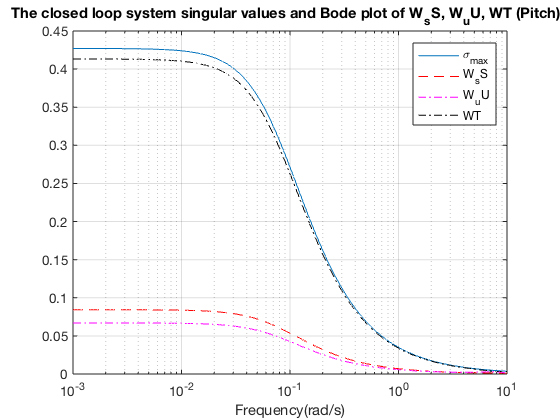

In [27]:
% Synthesize H∞ Controller
[k1 , CL1 , gamma1 , info1] = hinfsyn(G_theta_p , 1 , 1 , 'method' , 'ric' , 'Display' , 'on');

omega  = logspace(-3,1,300);
[mag_g1,phase_g1]=bode(CL1,omega);
sig_g1=sigma(CL1,omega);
semilogx(omega,sig_g1,omega,mag_g1(1,:),'--r',omega,mag_g1(2,:),'-.m',...
omega,mag_g1(3,:),'-.k')
title("The closed loop system singular values and Bode plot of W_sS, W_uU, WT (Pitch)  ");
xlabel("Frequency(rad/s)");
legend('\sigma_{max}','W_sS','W_uU','WT');
grid on;

In [28]:
tf(k1)


ans =
 
                                                                          
  0.6889 s^7 + 1.779e04 s^6 + 1.798e07 s^5 + 9.073e08 s^4 + 2.2e10 s^3    
                                                                          
                                    + 3.834e11 s^2 + 3.271e12 s + 9.242e12
                                                                          
  ------------------------------------------------------------------------
                                                                          
  s^8 + 2.586e04 s^7 + 2.713e07 s^6 + 2.371e09 s^5 + 1.036e11 s^4         
                                                                          
                     + 1.873e12 s^3 + 1.101e13 s^2 + 8.383e13 s + 8.382e10
                                                                          
 
Continuous-time transfer function.



#### 2.3. Nominal Performance Analysis

#### A) Closed-Loop Response to Step Input